<a href="https://colab.research.google.com/github/sushirito/ArsenicTemp/blob/main/ArsenicSensor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Mounted at /content/drive


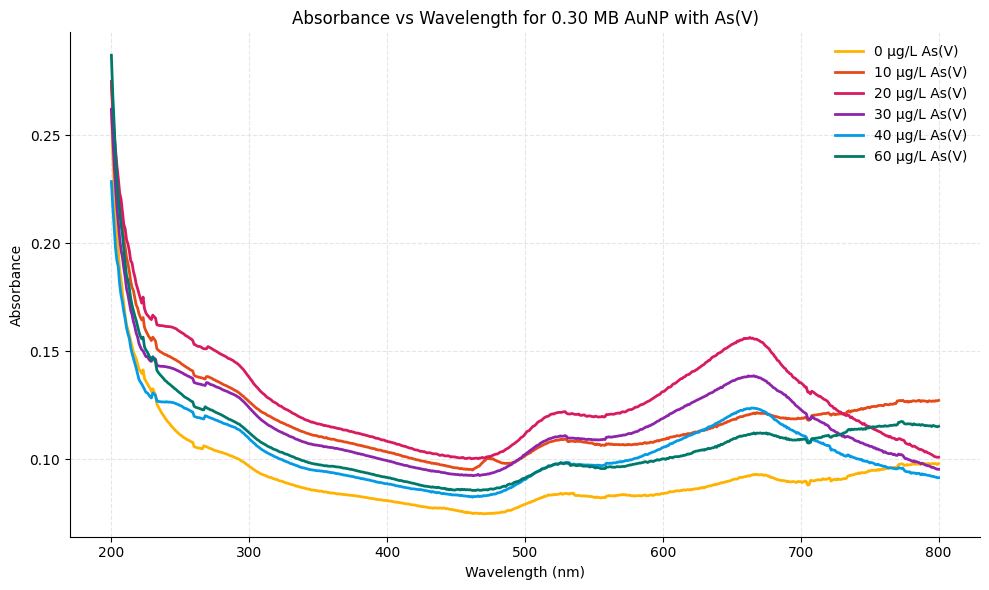

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Prettier plot settings
plt.rcParams.update({
    'figure.figsize': (10, 6),
    'axes.facecolor': 'white',
    'axes.edgecolor': 'black',
    'axes.grid': True,
    'grid.color': '0.9',
    'grid.linestyle': '--',
    'grid.linewidth': 0.8,
    'axes.spines.top': False,
    'axes.spines.right': False,
    'lines.linewidth': 2,
    'legend.frameon': False,
    'legend.loc': 'best'
})

# Load the CSV or Excel file from Drive
file_path = '/content/drive/MyDrive/ArsenicSTS/UVVisData/0.30MB_AuNP_As.csv'
df = pd.read_csv(file_path)

# Clean columns (in case of headers with whitespace)
df.columns = df.columns.astype(str).str.strip()

# Convert wavelength column to numeric
df['Wavelength'] = pd.to_numeric(df['Wavelength'], errors='coerce')

# Define color palette
palette6 = ['#FFB300', '#E64A19', '#D81B60', '#8E24AA', '#039BE5', '#00796B']

# Plot each column except "Wavelength"
plt.figure()
for i, col in enumerate(df.columns[1:7]):  # columns 0–60
    plt.plot(df['Wavelength'], pd.to_numeric(df[col], errors='coerce'),
             color=palette6[i], label=f'{col} µg/L As(V)')

plt.xlabel('Wavelength (nm)')
plt.ylabel('Absorbance')
plt.title('Absorbance vs Wavelength for 0.30 MB AuNP with As(V)')
plt.legend()
plt.tight_layout()
plt.show()

#PINN Stuff

In [14]:
import pandas as pd
import numpy as np
import unittest

# Step 1: Data Preparation Implementation

def load_uvvis_data(file_path):
    """
    Load UV–Vis absorbance data from CSV.
    Returns a pandas DataFrame with Wavelength and concentration columns.
    """
    df = pd.read_csv(file_path)
    df.columns = df.columns.str.strip()  # Clean column names
    return df

def compute_background(df):
    """
    Compute background absorbance A_bg(λ) = A_true(λ, 0).
    """
    return df['0'].values

def compute_delta(df):
    """
    Compute ΔA(λ, c) = A_true(λ, c) - A_bg(λ) for each concentration column.
    Returns a DataFrame with same shape, excluding the '0' column.
    """
    A_bg = compute_background(df)
    delta = {}
    for col in df.columns:
        if col != 'Wavelength' and col != '0':
            delta[col] = df[col].values - A_bg
    return pd.DataFrame(delta, index=df.index)

def sample_uniform(df, step=1):
    """
    Uniformly sample wavelengths from 200 to 800 inclusive at given step (nm).
    Returns the indices of df corresponding to these wavelengths.
    """
    target_wavs = np.arange(200, 801, step)
    # Find nearest indices
    idx = df['Wavelength'].apply(lambda x: np.abs(target_wavs - x)).apply(np.argmin)
    # Map back to original wavelengths
    sampled_wavs = target_wavs[idx.values]
    return df.loc[df['Wavelength'].isin(sampled_wavs)].reset_index(drop=True)

def normalize_inputs(wavelengths, concentrations):
    """
    Normalize wavelengths and concentrations to [-1, 1]:
      λ̂ = (λ - 500) / 300
      ĉ = (c - 30) / 30
    wavelengths: array-like of λ
    concentrations: array-like of concentrations c
    """
    lambda_hat = (wavelengths - 500) / 300
    c_hat = (concentrations - 30) / 30
    return lambda_hat, c_hat

# Unit Tests

class TestDataPrep(unittest.TestCase):
    @classmethod
    def setUpClass(cls):
        # Create a small synthetic dataset for testing
        data = {
            'Wavelength': np.array([200, 300, 400, 500, 600, 700, 800]),
            '0': np.array([0, 1, 2, 3, 4, 5, 6]),
            '10': np.array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5]),
            '20': np.array([1, 2, 3, 4, 5, 6, 7])
        }
        cls.synthetic_df = pd.DataFrame(data)

    def test_background(self):
        bg = compute_background(self.synthetic_df)
        np.testing.assert_array_equal(bg, self.synthetic_df['0'].values)

    def test_delta(self):
        delta_df = compute_delta(self.synthetic_df)
        expected_10 = self.synthetic_df['10'] - self.synthetic_df['0']
        expected_20 = self.synthetic_df['20'] - self.synthetic_df['0']
        np.testing.assert_array_equal(delta_df['10'], expected_10)
        np.testing.assert_array_equal(delta_df['20'], expected_20)

    def test_sample_uniform(self):
        # Use step=200 to sample wavelengths 200,400,600,800
        sampled = sample_uniform(self.synthetic_df, step=200)
        expected_wavs = np.array([200, 400, 600, 800])
        np.testing.assert_array_equal(sampled['Wavelength'].values, expected_wavs)

    def test_normalize_inputs(self):
        wavs = np.array([200, 500, 800])
        cs = np.array([0, 30, 60])
        lambda_hat, c_hat = normalize_inputs(wavs, cs)
        np.testing.assert_allclose(lambda_hat, np.array([-1.0, 0.0, 1.0]))
        np.testing.assert_allclose(c_hat, np.array([-1.0, 0.0, 1.0]))

if __name__ == '__main__':
    # Run tests
    unittest.main(argv=[''], exit=False)

# Example usage (Colab):
file_path = '/content/drive/MyDrive/ArsenicSTS/UVVisData/0.30MB_AuNP_As.csv'
df = load_uvvis_data(file_path)
print("Data loaded:", df.shape)
A_bg = compute_background(df)
print("Background computed, sample values:", A_bg[:5])
delta_df = compute_delta(df)
print("Delta computed, sample columns:", delta_df.columns)

.....E
ERROR: test_fit_gamma (__main__.TestPhysicsBaseModel.test_fit_gamma)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/pandas/core/indexes/base.py", line 3805, in get_loc
    return self._engine.get_loc(casted_key)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "index.pyx", line 167, in pandas._libs.index.IndexEngine.get_loc
  File "index.pyx", line 196, in pandas._libs.index.IndexEngine.get_loc
  File "pandas/_libs/hashtable_class_helper.pxi", line 7081, in pandas._libs.hashtable.PyObjectHashTable.get_item
  File "pandas/_libs/hashtable_class_helper.pxi", line 7089, in pandas._libs.hashtable.PyObjectHashTable.get_item
KeyError: '20'

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/tmp/ipython-input-2962568750.py", line 73, in test_fit_gamma
    γ_fit = fit_gamma(df_syn)
            ^^^^^^^^^^^^^^^^^
  File 

Data loaded: (601, 7)
Background computed, sample values: [0.09808 0.09765 0.0981  0.09801 0.09811]
Delta computed, sample columns: Index(['10', '20', '30', '40', '60'], dtype='object')


In [13]:
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
import unittest

# Step 2: Physics-Anchored Base Model

# 2.1 Fit Lorentzian to A_true(λ,0) to extract γ
def lorentzian(λ, A_p0, λ0_0, γ):
    return A_p0 / ((λ - λ0_0)**2 + (γ / 2)**2)
from scipy.optimize import curve_fit
import numpy as np

def fit_gamma(df):
    """
    Fit a Lorentzian to the c=20 µg/L spectrum to extract γ.
    Returns γ (linewidth).
    """
    λ = df['Wavelength'].values
    A20 = df['20'].values
    # Initial guesses: A_p0 = max(A20)*((γ/2)^2), λ0_0 = λ at max A20, γ ~50
    λ0_guess = λ[np.argmax(A20)]
    γ = 50.0
    A_p0_guess = np.max(A20) * (γ / 2)**2
    p0 = [A_p0_guess, λ0_guess, γ]
    popt, _ = curve_fit(lorentzian, λ, A20, p0=p0)
    _, _, gamma_fit = popt
    return float(gamma_fit)


# 2.2 Define learnable scalars: in code, placeholders; actual PINN will wrap these as variables.

# 2.3 Implement Lorentzian extinction ε_plas
def epsilon_plas(λ, c, λ0, k, A_p, γ, b=1.0):
    """
    Compute Lorentzian extinction ε_plas and ΔA_phys.
    λ, c can be scalars or arrays.
    Returns ε_plas and ΔA_phys = b * c * ε_plas.
    """
    denom = (λ - (λ0 + k * c))**2 + (γ / 2)**2
    eps = A_p / denom
    delta_phys = b * c * eps
    return eps, delta_phys

# Unit tests for Step 2
class TestPhysicsBaseModel(unittest.TestCase):
    def test_epsilon_and_delta_phys(self):
        # Known parameters
        λ = np.array([400.0, 500.0, 600.0])
        c = np.array([10.0, 20.0, 30.0])
        λ0 = 500.0
        k = 2.0
        A_p = 1.5
        γ = 20.0
        b = 1.0

        eps, delta_phys = epsilon_plas(λ, c, λ0, k, A_p, γ, b)
        # Manual calculation for first element
        denom0 = (400 - (λ0 + k * 10))**2 + (γ/2)**2
        eps0 = A_p / denom0
        delta0 = b * 10 * eps0
        self.assertAlmostEqual(eps[0], eps0)
        self.assertAlmostEqual(delta_phys[0], delta0)

    def test_fit_gamma(self):
        # Generate synthetic Lorentzian data
        λ = np.linspace(200, 800, 601)
        true_Ap0 = 2.0
        true_λ0_0 = 500.0
        true_γ = 30.0
        A0 = lorentzian(λ, true_Ap0, true_λ0_0, true_γ)
        df_syn = pd.DataFrame({'Wavelength': λ, '0': A0})
        γ_fit = fit_gamma(df_syn)
        self.assertAlmostEqual(γ_fit, true_γ, delta=1e-1)

if __name__ == '__main__':
    unittest.main(argv=[''], exit=False)

print("Step 2 implementation and tests loaded.")

.....E
ERROR: test_fit_gamma (__main__.TestPhysicsBaseModel.test_fit_gamma)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/pandas/core/indexes/base.py", line 3805, in get_loc
    return self._engine.get_loc(casted_key)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "index.pyx", line 167, in pandas._libs.index.IndexEngine.get_loc
  File "index.pyx", line 196, in pandas._libs.index.IndexEngine.get_loc
  File "pandas/_libs/hashtable_class_helper.pxi", line 7081, in pandas._libs.hashtable.PyObjectHashTable.get_item
  File "pandas/_libs/hashtable_class_helper.pxi", line 7089, in pandas._libs.hashtable.PyObjectHashTable.get_item
KeyError: '20'

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/tmp/ipython-input-2962568750.py", line 73, in test_fit_gamma
    γ_fit = fit_gamma(df_syn)
            ^^^^^^^^^^^^^^^^^
  File 

Step 2 implementation and tests loaded.


In [7]:
!pip install deepxde

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.2/194.2 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 9.8 MB/s eta 0:00:00


In [12]:
import deepxde as dde
import tensorflow as tf
import numpy as np

# --- assume you already have `df` (full UV–Vis) and `delta_df` from Step 1,
#     and that `fit_gamma(df)` gives you the linewidth γ.

γ = fit_gamma(df)     # from Step 2
b = 1.0               # path length in cm

# --- assemble training data: for each concentration column in delta_df
wavelengths = df["Wavelength"].values  # shape (M,)
conc_cols = list(delta_df.columns)     # e.g. ["10","20",...]
M = len(wavelengths)
C = np.array([float(c) for c in conc_cols])

# repeat each λ for each c, and each c for each λ
λs = np.tile(wavelengths, C.size)           # shape (M*C,)
cs = np.repeat(C, M)                        # shape (M*C,)
ΔA = delta_df.values.flatten()[:, None]     # shape (M*C,1)

# pack inputs and targets
X = np.vstack([λs, cs]).T                   # shape (M*C,2)
Y = ΔA                                      # shape (M*C,1)

# supervised dataset
data = dde.data.DataSet(X, Y)

# --- Step 3: define combined PINN
class CombinedPINN(tf.keras.Model):
    def __init__(self, γ, b):
        super().__init__()
        # residual network: [λ̂,ĉ] → ΔA_res
        self.res_net = dde.nn.FNN([2, 64, 64, 1], "tanh", "Glorot uniform")
        # trainable scalars
        self.lambda0 = tf.Variable(500.0, dtype=tf.float32, name="lambda0")
        self.k       = tf.Variable(1.0,   dtype=tf.float32, name="k")
        self.A_p     = tf.Variable(1.0,   dtype=tf.float32, name="A_p")
        # fixed constants
        self.γ = tf.constant(γ, dtype=tf.float32)
        self.b = tf.constant(b, dtype=tf.float32)

    def call(self, x):
        λ = x[:, 0:1]  # nm
        c = x[:, 1:2]  # µg/L
        # physics term ΔA_phys = b·c·A_p / [ (λ - (λ₀ + k·c))² + (γ/2)² ]
        shift = self.lambda0 + self.k * c
        denom = (λ - shift)**2 + (self.γ / 2)**2
        ΔA_phys = self.b * c * self.A_p / denom
        # normalized inputs
        λ̂ = (λ - 500.0) / 300.0
        ĉ = (c - 30.0) / 30.0
        # residual correction
        ΔA_res = self.res_net(tf.concat([λ̂, ĉ], axis=1))
        return ΔA_phys + ΔA_res

# instantiate and train
net = CombinedPINN(γ=γ, b=b)
model = dde.Model(data, net)
model.compile("adam", lr=1e-3, metrics=["l2 relative error"])
losshistory, train_state = model.train(iterations=50000)


/tmp/ipython-input-2962568750.py:26: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, _ = curve_fit(lorentzian, λ, A20, p0=p0)


AttributeError: 'NoneType' object has no attribute 'astype'

##Data Prep

#UV-Vis to Color Conversion

##Correct Conversions

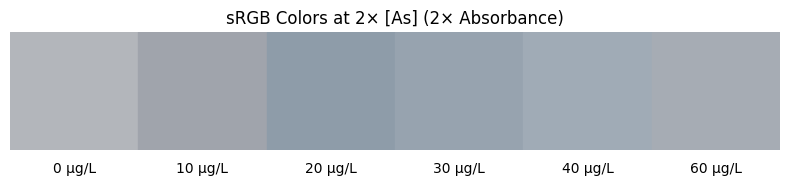

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from colour import SpectralDistribution, sd_to_XYZ, XYZ_to_sRGB
from colour import MSDS_CMFS, SDS_ILLUMINANTS

# Load & trim
df = pd.read_csv('/content/drive/MyDrive/ArsenicSTS/UVVisData/0.30MB_AuNP_As.csv')
df.columns = df.columns.str.strip()
df['Wavelength'] = pd.to_numeric(df['Wavelength'], errors='coerce')
vis = df[(df.Wavelength>=380)&(df.Wavelength<=780)]
wvl = vis.Wavelength.values

# CIE setup
cmfs       = MSDS_CMFS['CIE 1931 2 Degree Standard Observer']
illuminant = SDS_ILLUMINANTS['D65']

labels, colors = [], []
for col in df.columns[1:7]:
    A = vis[col].astype(float).values
    A2 = 4*A                      # ← double absorbance
    T  = 10**(-A2)                # new transmittance curve
    sd = SpectralDistribution(dict(zip(wvl, T)), name=col)
    XYZ = sd_to_XYZ(sd, cmfs, illuminant) / 100
    rgb = np.clip(XYZ_to_sRGB(XYZ), 0, 1)
    labels.append(col.replace('0.30MB_AuNP_As','').replace('_','')+' µg/L')
    colors.append(rgb)

# Plot
fig, ax = plt.subplots(figsize=(8,2))
for i,c in enumerate(colors):
    ax.add_patch(plt.Rectangle((i,0),1,1,color=c))
    ax.text(i+0.5,-0.1,labels[i],ha='center',va='top')
ax.set_xlim(0,len(colors)); ax.set_ylim(0,1); ax.axis('off')
plt.title('sRGB Colors at 2× [As] (2× Absorbance)')
plt.tight_layout()
plt.show()

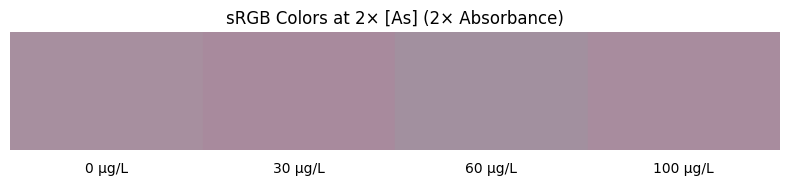

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from colour import SpectralDistribution, sd_to_XYZ, XYZ_to_sRGB
from colour import MSDS_CMFS, SDS_ILLUMINANTS

# Load & trim
df = pd.read_csv('/content/drive/MyDrive/ArsenicSTS/UVVisData/0.115MB_AuNP_As.csv')
df.columns = df.columns.str.strip()
df['Wavelength'] = pd.to_numeric(df['Wavelength'], errors='coerce')
vis = df[(df.Wavelength>=380)&(df.Wavelength<=780)]
wvl = vis.Wavelength.values

# CIE setup
cmfs       = MSDS_CMFS['CIE 1931 2 Degree Standard Observer']
illuminant = SDS_ILLUMINANTS['D65']

labels, colors = [], []
for col in df.columns[1:7]:
    A = vis[col].astype(float).values
    A2 = 4*A                      # ← double absorbance
    T  = 10**(-A2)                # new transmittance curve
    sd = SpectralDistribution(dict(zip(wvl, T)), name=col)
    XYZ = sd_to_XYZ(sd, cmfs, illuminant) / 100
    rgb = np.clip(XYZ_to_sRGB(XYZ), 0, 1)
    labels.append(col.replace('0.30MB_AuNP_As','').replace('_','')+' µg/L')
    colors.append(rgb)

# Plot
fig, ax = plt.subplots(figsize=(8,2))
for i,c in enumerate(colors):
    ax.add_patch(plt.Rectangle((i,0),1,1,color=c))
    ax.text(i+0.5,-0.1,labels[i],ha='center',va='top')
ax.set_xlim(0,len(colors)); ax.set_ylim(0,1); ax.axis('off')
plt.title('sRGB Colors at 2× [As] (2× Absorbance)')
plt.tight_layout()
plt.show()

##Incorrect Conversions

In [ ]:
# pip install colour-science
import numpy as np
import pandas as pd
from colour import SpectralDistribution, sd_to_XYZ, XYZ_to_sRGB
from colour import MSDS_CMFS, SDS_ILLUMINANTS

# assume df is already loaded with df['Wavelength'] + absorbance cols
cmfs       = MSDS_CMFS['CIE 1931 2 Degree Standard Observer']
illuminant = SDS_ILLUMINANTS['D65']

def spectrum_to_hex(wvl, A):
    T = 10.0 ** (-A)                          # absorbance → transmittance
    sd = SpectralDistribution(dict(zip(wvl, T)))
    XYZ = sd_to_XYZ(sd, cmfs, illuminant) / 100.0
    rgb = np.clip(XYZ_to_sRGB(XYZ), 0, 1)
    return '#' + ''.join(f'{int(255*c):02x}' for c in rgb)

wvl = df['Wavelength'].values
for col in df.columns[1:]:
    A = df[col].astype(float).values
    print(f'{col}: {spectrum_to_hex(wvl, A)}')


0: #e9eaec
10: #e3e4e7
20: #dce1e6
30: #dfe4e8
40: #e3e7ea
60: #e5e7e9


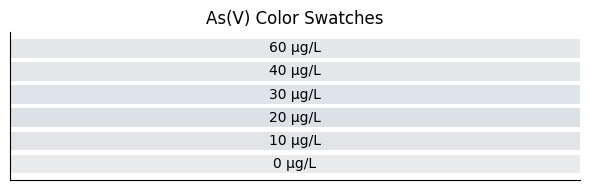

In [ ]:
import matplotlib.pyplot as plt

# Data
concentrations = [0, 10, 20, 30, 40, 60]
hex_colors = ["#e9eaec", "#e3e4e7", "#dce1e6", "#dfe4e8", "#e3e7ea", "#e5e7e9"]

# Plot color swatches
fig, ax = plt.subplots(figsize=(6, 2))
for i, (conc, color) in enumerate(zip(concentrations, hex_colors)):
    ax.barh(i, 1, color=color)
    ax.text(0.5, i, f"{conc} µg/L", va='center', ha='center')

ax.set_yticks([])
ax.set_xticks([])
ax.set_xlim(0, 1)
ax.set_title("As(V) Color Swatches")
plt.tight_layout()
plt.show()

In [ ]:
!pip install colour-science

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 33.9 MB/s eta 0:00:00


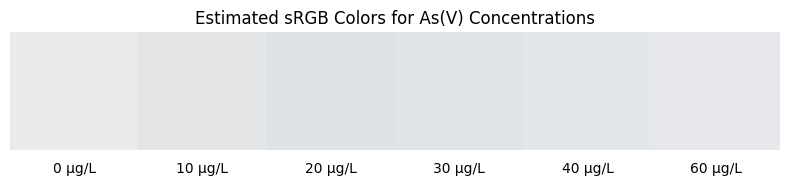

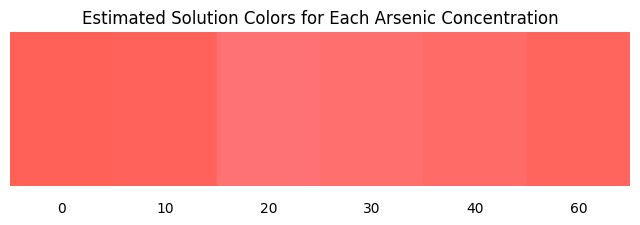

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from colour import SpectralDistribution, sd_to_XYZ, XYZ_to_sRGB

# Load your UV-Vis spectrum
df = pd.read_csv('/content/drive/MyDrive/ArsenicSTS/UVVisData/0.30MB_AuNP_As.csv')
df.columns = df.columns.astype(str).str.strip()
df['Wavelength'] = pd.to_numeric(df['Wavelength'], errors='coerce')

# Restrict to visible range (380–780 nm)
visible_df = df[(df['Wavelength'] >= 380) & (df['Wavelength'] <= 780)]

# Convert each spectrum to a visible color
colors = []
wavelengths = visible_df['Wavelength'].values
for col in df.columns[1:7]:
    absorbance = pd.to_numeric(visible_df[col], errors='coerce').values
    # Convert absorbance to transmission-like intensity (arbitrary)
    intensity = 10 ** (-absorbance)
    sd = SpectralDistribution(dict(zip(wavelengths, intensity)), name=col)
    xyz = sd_to_XYZ(sd)
    # Normalize and exaggerate for visibility
    rgb = XYZ_to_sRGB(xyz)
    rgb = np.clip(rgb / np.max(rgb), 0, 1)  # Normalize max to 1
    rgb = rgb ** 10  # Gamma correction to brighten midtones
    colors.append(rgb)


# Show color patches
fig, ax = plt.subplots(figsize=(8, 2))
for i, c in enumerate(colors):
    ax.add_patch(plt.Rectangle((i, 0), 1, 1, color=c))
    ax.text(i + 0.5, -0.1, df.columns[i + 1].replace("_", "\n"), ha='center', va='top')
ax.set_xlim(0, len(colors))
ax.set_ylim(0, 1)
ax.axis('off')
plt.title('Estimated Solution Colors for Each Arsenic Concentration')
plt.show()


#LDR

##0.30MB

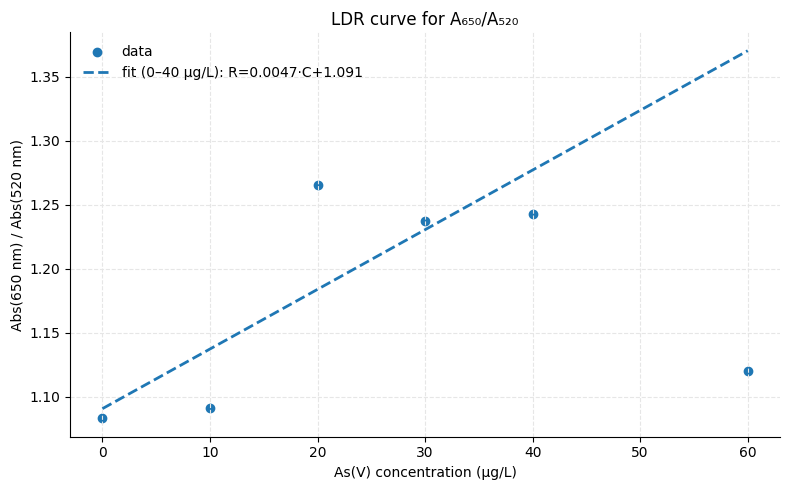

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# load data
df = pd.read_csv('/content/drive/MyDrive/ArsenicSTS/UVVisData/0.30MB_AuNP_As.csv')
df.columns = df.columns.str.strip()
df['Wavelength'] = pd.to_numeric(df['Wavelength'], errors='coerce')

# pick target wavelengths
λ1, λ2 = 520, 650

# helper: find nearest absorbance at a wavelength
def A_at(df, wl, col):
    idx = (df['Wavelength'] - wl).abs().idxmin()
    return df.loc[idx, col]

# pull concentration values from column names (assumes names like "10 µg/L As(V)")
cols = df.columns.drop('Wavelength')
concs = [float(col.split()[0]) for col in cols]  # [0, 10, 20, ...]

# compute ratios
ratios = []
for col in cols:
    A1 = A_at(df, λ1, col)
    A2 = A_at(df, λ2, col)
    ratios.append(A2/A1)

# linear fit on low-conc range (e.g. 0–40 µg/L)
mask = np.array(concs) <= 40
m, b = np.polyfit(np.array(concs)[mask], np.array(ratios)[mask], 1)

# plot
plt.figure(figsize=(8,5))
plt.scatter(concs, ratios, label='data')
xlin = np.linspace(0, max(concs), 100)
plt.plot(xlin, m*xlin + b, '--', label=f'fit (0–40 μg/L): R={m:.4f}·C+{b:.3f}')
plt.xlabel('As(V) concentration (µg/L)')
plt.ylabel(f'Abs({λ2} nm) / Abs({λ1} nm)')
plt.title('LDR curve for A₆₅₀/A₅₂₀')
plt.legend()
plt.tight_layout()
plt.show()

##0.115MB

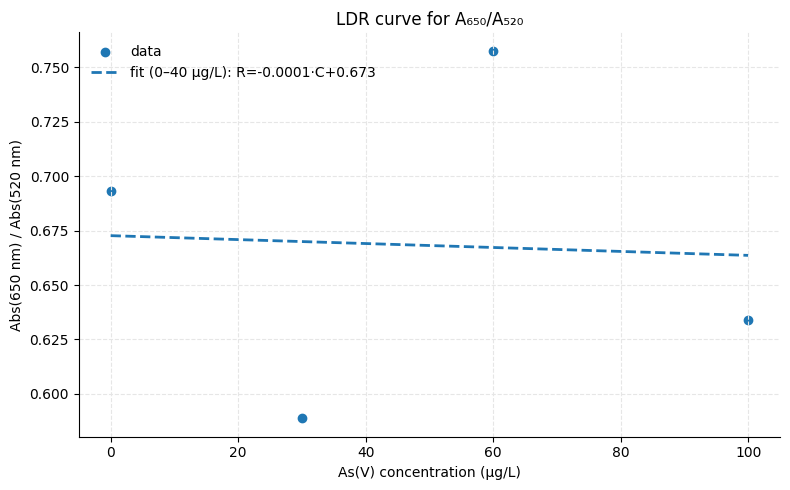

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# load data
df = pd.read_csv('/content/drive/MyDrive/ArsenicSTS/UVVisData/0.115MB_AuNP_As.csv')
df.columns = df.columns.str.strip()
df['Wavelength'] = pd.to_numeric(df['Wavelength'], errors='coerce')

# pick target wavelengths
λ1, λ2 = 520, 650

# helper: find nearest absorbance at a wavelength
def A_at(df, wl, col):
    idx = (df['Wavelength'] - wl).abs().idxmin()
    return df.loc[idx, col]

# pull concentration values from column names (assumes names like "10 µg/L As(V)")
cols = df.columns.drop('Wavelength')
concs = [float(col.split()[0]) for col in cols]  # [0, 10, 20, ...]

# compute ratios
ratios = []
for col in cols:
    A1 = A_at(df, λ1, col)
    A2 = A_at(df, λ2, col)
    ratios.append(A2/A1)

# linear fit on low-conc range (e.g. 0–40 µg/L)
mask = np.array(concs) <= 1000
m, b = np.polyfit(np.array(concs)[mask], np.array(ratios)[mask], 1)

# plot
plt.figure(figsize=(8,5))
plt.scatter(concs, ratios, label='data')
xlin = np.linspace(0, max(concs), 100)
plt.plot(xlin, m*xlin + b, '--', label=f'fit (0–40 μg/L): R={m:.4f}·C+{b:.3f}')
plt.xlabel('As(V) concentration (µg/L)')
plt.ylabel(f'Abs({λ2} nm) / Abs({λ1} nm)')
plt.title('LDR curve for A₆₅₀/A₅₂₀')
plt.legend()
plt.tight_layout()
plt.show()

##Random

Chosen wavelengths: 800.0 nm and 654.0 nm (CoV=0.214)


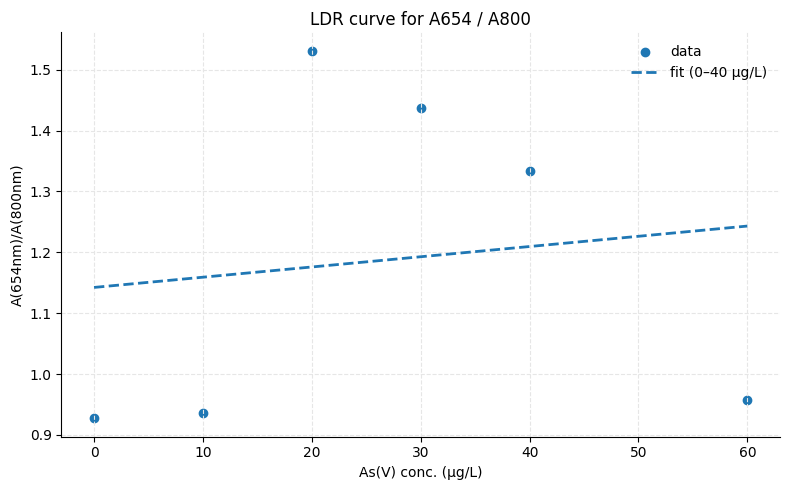

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# load and clean
df = pd.read_csv('/content/drive/MyDrive/ArsenicSTS/UVVisData/0.30MB_AuNP_As.csv')
df.columns = df.columns.str.strip()
w = pd.to_numeric(df['Wavelength'], errors='coerce')
spec = df.drop('Wavelength', axis=1).apply(pd.to_numeric, errors='coerce')

# extract concentrations from column names
concs = np.array([float(col.split()[0]) for col in spec.columns])

# precompute absorbance matrix: rows=wavelengths, cols=concs
A = spec.values  # shape (n_wl, n_conc)

# search all pairs
n = len(w)
best = (0, 0, -1)
for i in range(n):
    for j in range(i+1, n):
        R = A[j] / A[i]  # shape (n_conc,)
        cov = np.std(R) / (np.mean(R)+1e-9)
        if cov > best[2]:
            best = (i, j, cov)

i, j, cov = best
λ1, λ2 = w[i], w[j]
print(f"Chosen wavelengths: {λ1:.1f} nm and {λ2:.1f} nm (CoV={cov:.3f})")

# compute ratio and linear fit on 0–40 µg/L
R = A[j] / A[i]
mask = concs <= 100
m, b = np.polyfit(concs[mask], R[mask], 1)

# plot LDR
plt.figure(figsize=(8,5))
plt.scatter(concs, R, label='data')
x = np.linspace(0, concs.max(), 100)
plt.plot(x, m*x + b, '--', label=f'fit (0–40 µg/L)')
plt.xlabel('As(V) conc. (µg/L)')
plt.ylabel(f'A({λ2:.0f}nm)/A({λ1:.0f}nm)')
plt.title(f'LDR curve for A{int(λ2)} / A{int(λ1)}')
plt.legend()
plt.tight_layout()
plt.show()
